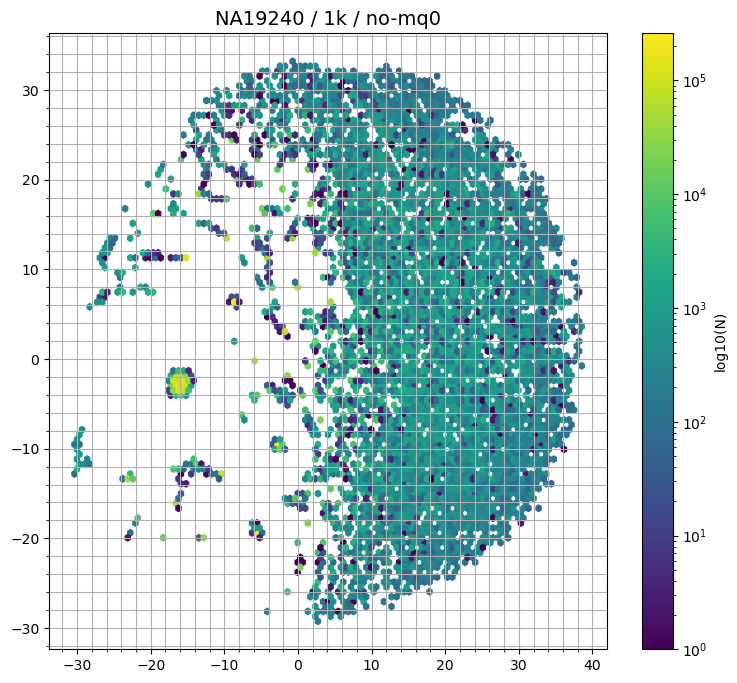

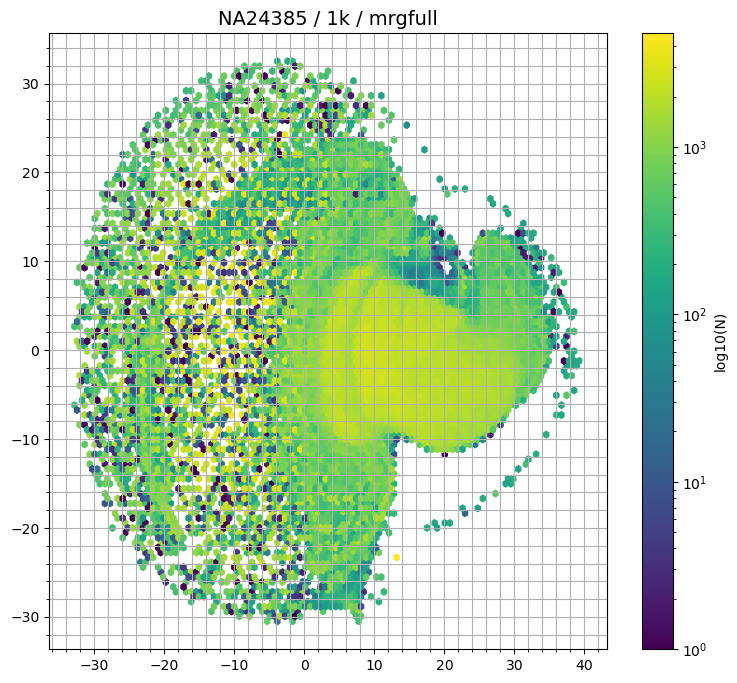

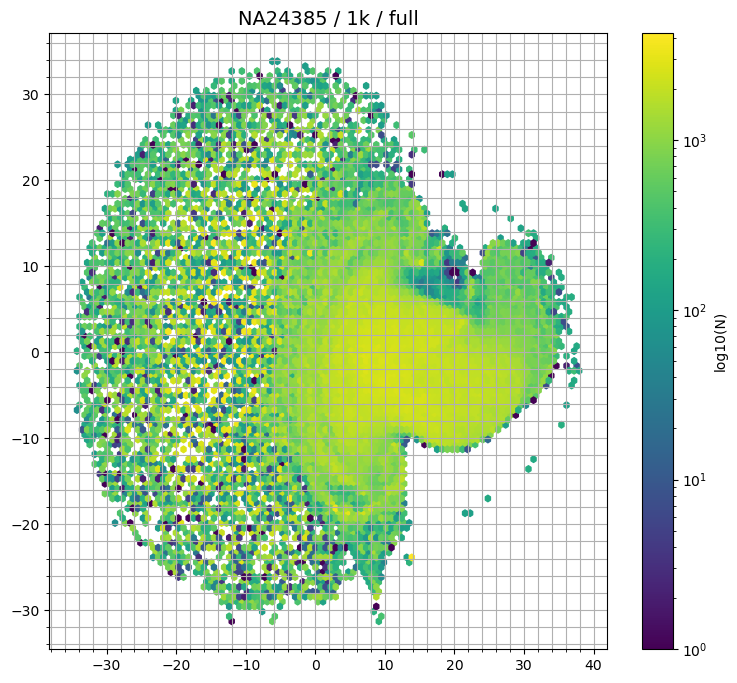

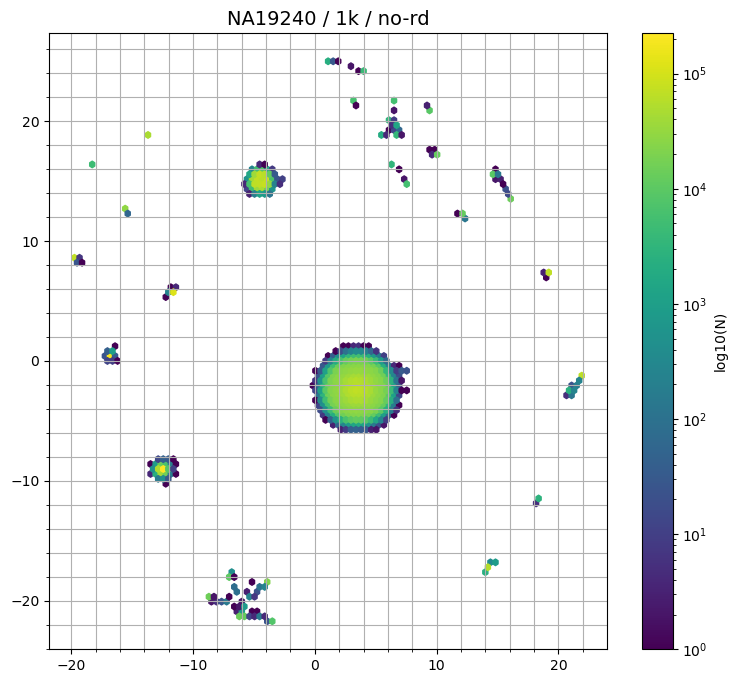

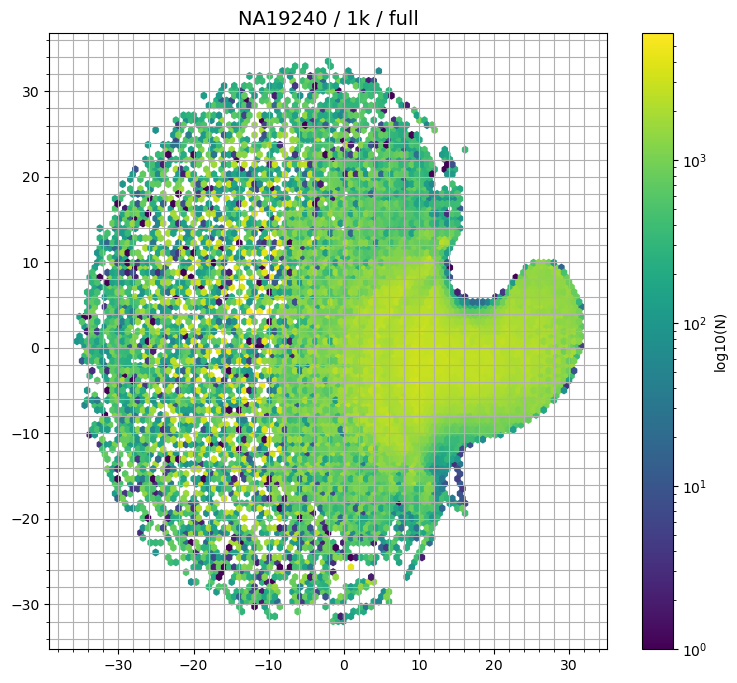

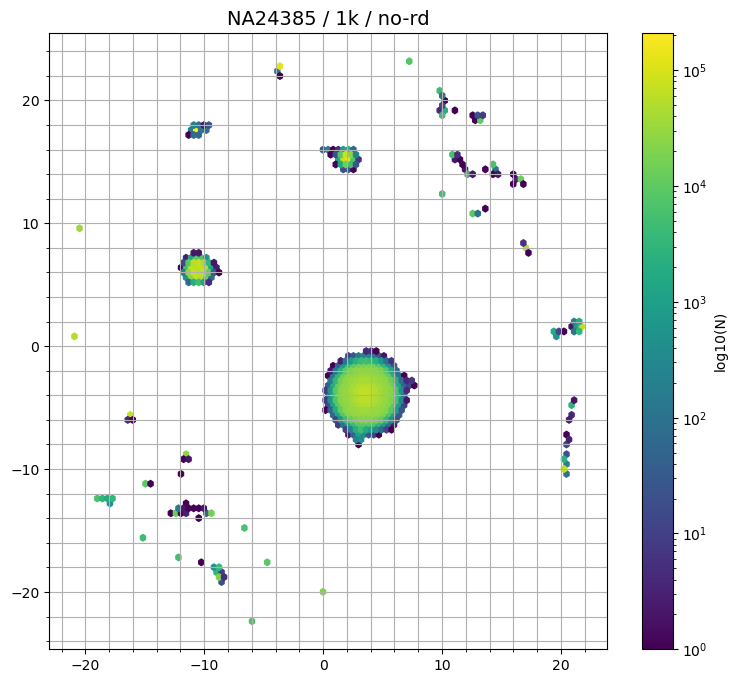

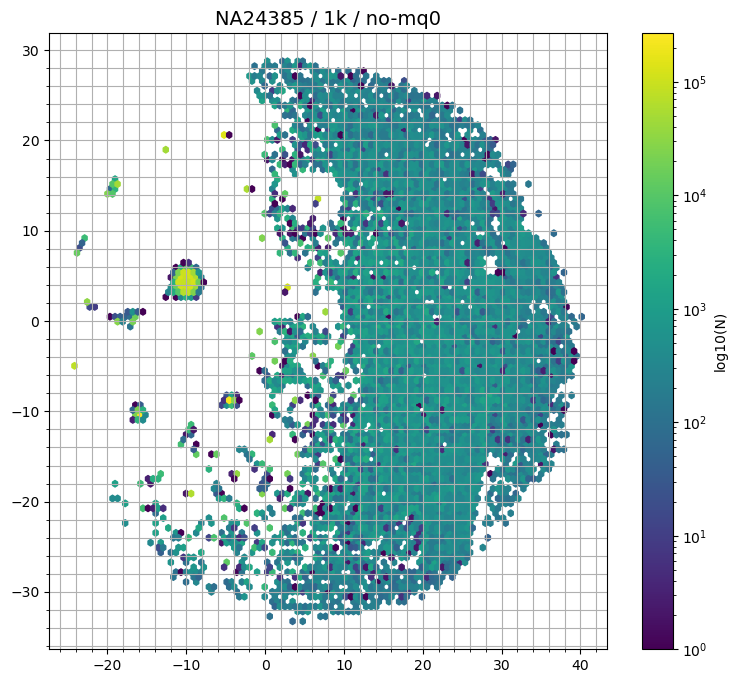

In [3]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import pathlib as pl
import numpy as np
import collections as col
import itertools as itt

root_folder = pl.Path("/home/ebertp/work/projects/hgsvc/2024_asm_label_qc")
#root_folder = pl.Path("/home/ebertp/work/code/cubi/project-run-hgsvc-hybrid-assemblies/workflow/scripts/asm_label_qc")

datasets = root_folder.glob("*.npy")

def plot_density(embedded_data, title=None):

    fig, ax = plt.subplots(figsize=(9,8))
    
    hb = ax.hexbin(
        embedded_data[:, 0],
        embedded_data[:, 1],
        bins="log"
    )
    ax.minorticks_on()
    plt.grid(visible=True, which="both")
    if title is not None:
        ax.set_title(title, fontsize=14)

    cb = fig.colorbar(hb, ax=ax)
    cb.set_label('log10(N)')
  
    return


def plot_data_excerpt(binned_data, select_rows, title=None):

    fig, ax = plt.subplots(figsize=(10,6))

    #plot_columns = [c for c in binned_data.columns if not c.startswith("rd_")]

    subset = binned_data.loc[select_rows, :]
    ax.boxplot(
        subset
    )
    ax.set_xticks(np.arange(1, subset.shape[1]+1))
    ax.set_xticklabels(subset.columns, fontsize=10, rotation=90)

    if title is not None:
        ax.set_title(title, fontsize=14)

    return


axis_select = {
    ("NA24385", "1k", "no-rd"): [
        ((1,7), (0, -4)),
        ((-9, -12), (6, 8)),
        ((0,4),(14,16))
    ],
    ("NA24385", "1k", "no-mq0"): [
        ((-8, -12), (0,-4)),
        ((10,30), (0,20))
    ],
    ("NA19240", "1k", "no-mq0"): [
        ((-14, -18), (0, -4)),
        ((10,30), (0,20))
    ],
    ("NA19240", "1k", "no-rd"): [
        ((0, 6), (0, -6)),
        ((-2, -6), (14,16)),
        ((-4,-8), (-18,-22))
    ]
}

for data_file in datasets:
    name_parts = data_file.name.split(".")
    sample = name_parts[0]
    if sample not in ["NA19240", "NA24385"]:
        continue
    resolution = name_parts[2]
    fset = name_parts[3]

    if resolution != "1k":
        continue
    
    prefix = ".".join(name_parts[:4])
    plot_label = f"{sample} / {resolution} / {fset}"

    embedding = np.load(data_file)
    plot_density(embedding, plot_label)
    continue
    raise

    lookup = (sample, resolution, fset)
    if lookup not in axis_select:
        continue
    
    binned_dataset = data_file.parent.joinpath(
        f"{prefix}.binned-dataset.tsv.gz"
    ).resolve(strict=True)
    bin_data = pd.read_csv(binned_dataset, sep="\t", header=0)

    region_cache = data_file.parent.joinpath(
        "region_cache",
        f"{sample}.vrk-ps-sseq.assessem-cache.h5"
    )
    gs = pd.read_hdf(region_cache, "/genome_size")
    gs["bin_label"] = gs["sequence"].apply(lambda x: x.split("-")[0])

    genome_bins = gs.loc[gs.index[1:], "end"].values // 1000
    genome_bins = np.insert(genome_bins, 0, 0)

    bin_center = (bin_data.index.values * 1000) + 500

    label_map = {}
    bin_num = 0
    for label, (left, right) in zip(gs["bin_label"].iloc[1:], itt.pairwise(genome_bins)):
        bin_num += 1
        label_map[bin_num] = label
        
    for ((x1,x2), (y1,y2)) in axis_select[lookup]:
        select_x_rows = None
        select_y_rows = None
        if any(x < 0 for x in (x1,x2)):
            assert x1 > x2
            select_x_rows = (embedding[:, 0] <= x1) & (embedding[:, 0] >= x2)
        else:
            assert x1 < x2
            select_x_rows = (embedding[:, 0] >= x1) & (embedding[:, 0] <= x2)

        if any(y < 0 for y in (y1, y2)):
            assert y1 > y2
            select_y_rows = (embedding[:, 1] <= y1) & (embedding[:, 1] >= y2)
        else:
            assert y1 < y2
            select_y_rows = (embedding[:, 1] >= y1) & (embedding[:, 1] <= y2)

        selector = select_x_rows & select_y_rows
        if sum(selector) < 1000:
            raise ValueError

        selected_bins = bin_center[selector]
        bin_labels = pd.Series(np.digitize(selected_bins, genome_bins)).replace(label_map).value_counts()
        bin_labels = col.Counter(dict((k,v) for k,v in bin_labels.items()))

        info_label = (
            f"H0: {bin_labels['unassigned']} "
            f"/ H1: {bin_labels['haplotype1']} "
            f"/ H2: {bin_labels['haplotype2']}"
        )

        plot_data_excerpt(bin_data, selector, f"{sample }/ {resolution} / {fset}\n{info_label}\nx({x1},{x2}) / y({y1},{y2})")


    
    


